In [50]:
import pandas as pd
import os
import random
import chardet
import requests
import json
import numpy as np
from urllib3.util.retry import Retry
import openai
from requests.adapters import HTTPAdapter
import os
import pickle
import matplotlib.pyplot as plt

In [51]:
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-FullMovies\Emotion_scores\scores_allMovies_resample.pkl', 'rb') as f:
    scores_dict = pickle.load(f)
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-FullMovies\Emotion_scores\times_allMovies_resample.pkl', 'rb') as f:
    time_dict= pickle.load(f)

print(len(scores_dict.keys()))
print(len(time_dict.keys()))

102
102


### Dynamic indices

In [3]:
# Autocorrelation
def exp_decay(x, A, lambda_):
    return A * np.exp(-lambda_ * x)

def power_law(x, A, alpha):
    return A * x**(-alpha)

def r_squared(y, y_fit):
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1 - ss_res / ss_tot

# auto-correlation
# from scipy.signal import correlate
from scipy.optimize import curve_fit
from scipy import stats

colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
keys = list(scores_dict.keys())
print(len(keys))

r2_exp_all = np.zeros((len(keys),6))
r2_power_all = np.zeros((len(keys),6))
lambda_movies = np.zeros((len(keys), 6))
A_exp_movies = np.zeros((len(keys), 6))
for i in range(len(keys)):
    # plt.figure(figsize=(13,5))
    # print(scores_dict[keys[i]].shape)
    scores_norm = (scores_dict[keys[i]] - np.mean(scores_dict[keys[i]], axis=0, keepdims=True)) / np.std(scores_dict[keys[i]], axis=0, keepdims=True)
    for j in range(6):
        auto_corr = np.correlate(scores_norm[:,j], scores_norm[:,j], mode='full')
        lags = np.arange(1, len(scores_norm[:,j]))
        popt, pcov = curve_fit(exp_decay, lags, auto_corr[len(scores_norm[:,j]):], p0=[1, 0.1])  # 初始猜测 A=1, lambda=0.1
        A_fitted, lambda_fitted = popt
        lambda_movies[i, j] = lambda_fitted
        A_exp_movies[i, j] = A_fitted
        
        y_fit = exp_decay(lags, *popt)
        r2_exp = r_squared(auto_corr[len(scores_norm[:,j]):], y_fit)
        
        popt, pcov = curve_fit(power_law, lags, auto_corr[len(scores_norm[:,j]):], p0=[1, 1])
        A_fitted, alpha_fitted = popt
        print(alpha_fitted)
        
        y_fit = power_law(lags, *popt)
        r2_power = r_squared(auto_corr[len(scores_norm[:,j]):], y_fit)
        print(r2_exp, r2_power)
        r2_exp_all[i,j] = r2_exp
        r2_power_all[i,j] = r2_power

102
0.7151042954326338
0.5426412875232871 0.44346283337858916
0.7501067818773204
0.5095680854209061 0.41333782152475473
0.5728742829828205
0.6530683634115086 0.35282856501200865
0.6053939073640651
0.5642195797706886 0.3651171529014834
0.6252819016517881
0.5623109966371143 0.38348322380643574
0.5939304376593788
0.6089456090847689 0.34946436552117377
0.695905211666041
0.460400234185096 0.4208994511080013
0.7233225894672421
0.5125102508040383 0.4032791763091885
0.5662623101343485
0.677707850094972 0.3050226054079719
0.6050606880267433
0.6498363761874076 0.3569776051238035
0.6056913829182394
0.6733945667139298 0.39630277188696017
0.6051911978137308
0.5302323211396217 0.35240607180352457
0.7180096978485819
0.5087891839592702 0.44228679764060164
0.7437727346008265
0.4745315268220991 0.3998515676659691
0.6761149648492638
0.5847967404969558 0.4293361914243965
0.6197246558044456
0.5329694511852356 0.3172169595069071
0.6364738901657004
0.5105227788069845 0.3656574261852491
0.6985277080899558
0.4

C:\Users\Windows\AppData\Local\Temp\ipykernel_22716\1836694081.py:3: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-lambda_ * x)
C:\Users\Windows\AppData\Local\Temp\ipykernel_22716\1836694081.py:3: RuntimeWarning: overflow encountered in multiply
  return A * np.exp(-lambda_ * x)
C:\Users\Windows\AppData\Local\Temp\ipykernel_22716\1836694081.py:6: RuntimeWarning: overflow encountered in power
  return A * x**(-alpha)
C:\Users\Windows\AppData\Local\Temp\ipykernel_22716\1836694081.py:6: RuntimeWarning: overflow encountered in multiply
  return A * x**(-alpha)


0.6962461668106976
0.45839509000483447 0.47180677572602847
0.7741241358244277
0.4526832474135176 0.41998648863184673
0.6811612051353445
0.6050947950718608 0.36715290344176665
0.653272084026219
0.5581284794411869 0.3118099675820709
0.6672791165767538
0.5662330415415144 0.3364860767749711
0.7328218888720346
0.4572549572393596 0.3749624380963338
0.6787793737033027
0.44030300021552793 0.3376516300911939
0.8276131941524831
0.48770920453010247 0.3885204489621965
0.6476030266955408
0.4437563079645661 0.3995632048037553
0.6509349803697049
0.40981628819521154 0.27068180259033403
0.6602516018334311
0.4977396137214274 0.3485869857490126
0.660927032951594
0.4734291834076084 0.38572267235931057
0.6213611399534866
0.5869353156727617 0.3617317614640332
0.6470558666901084
0.644532704746781 0.4950925202212859
0.6195607928696523
0.5345179534928015 0.3925487803680838
0.6585117320278983
0.4018033948288625 0.2174671799409148
0.6642592711379723
0.482541889955482 0.28336030506496723
0.6491183631905723
0.5023

Batman_darknight


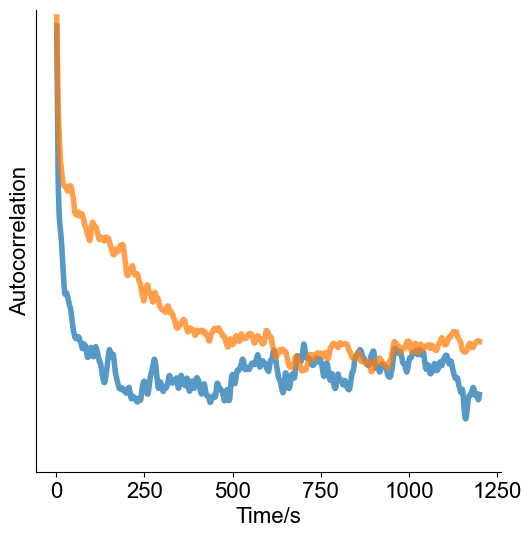

In [4]:
colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Arial'
for i in range(1):
    plt.figure(figsize=(6,6))
    print(keys[i])
    scores_norm = (scores_dict[keys[i]] - np.mean(scores_dict[keys[i]], axis=0, keepdims=True)) / np.std(scores_dict[keys[i]], axis=0, keepdims=True)
    for j in [1,2]:
        auto_corr = np.correlate(scores_norm[:,j], scores_norm[:,j], mode='full')
        lags = np.arange(1, len(scores_norm[:,j]))
        # fitted = A_exp_movies[i,j] * np.exp(-lambda_movies[i,j] * lags)
        plt.plot(lags[:1200], auto_corr[len(scores_norm[:,j]):len(scores_norm[:,j])+1200], color=colors[j], alpha=0.75, linewidth=4)
        # plt.plot(lags[:1200], fitted[:1200], '--')
    plt.xlabel('Time/s')
    plt.yticks([])
    plt.ylabel('Autocorrelation')
    plt.ylim([-1200,4500])
    # plt.legend(['Surprise - original', 'Surprise - fitted', 'Sadness - original', 'Sadness - fitted'])
    # plt.savefig('figures/autocorr_surprise_sadness_example.jpg')
    ax = plt.gca()
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

    plt.show()

In [5]:
# Hurst component (self-similarity)
from hurst import compute_Hc, random_walk
Hurst_all = np.zeros((len(keys),6))
for i in range(len(keys)):
    for j in range(6):
        H, c, data = compute_Hc(scores_dict[keys[i]][:,j]+1., kind='price', simplified=True)
        Hurst_all[i,j] = H
print(np.mean(Hurst_all, axis=0), np.std(Hurst_all, axis=0))

[0.36266071 0.35564406 0.37417912 0.38570348 0.38430116 0.35359479] [0.06301387 0.05027893 0.03937971 0.04365562 0.04317023 0.04321926]


In [6]:
# Controllability
from scipy.linalg import inv, norm
from scipy.optimize import minimize_scalar
import mou_model as pm

def system_identification(time_series):
    
    mou = pm.MOU()
    mou.fit(time_series, lag = 1)
    Jacobian = np.copy(mou.J)
    Sigma = np.copy(mou.Sigma)
    
    print(' - model fit of empirical covariances: ', end = '')
    print(mou.d_fit['correlation'])
    
    return Jacobian, Sigma

def average_controllability(Jacobian, Sigma):

    integral = -inv(Jacobian + Jacobian.T)
    AC = np.sqrt(np.diag(np.dot(np.dot(Sigma.T, integral), Sigma)))
    
    return AC

def modal_controllability(Jacobian, Sigma):

    n = Jacobian.shape[0]
    MC = np.array([-1/minimize_scalar(lambda omega: -norm(Sigma[i,i]*inv(1j*omega*np.eye(n)-Jacobian)[:,i], 2)).fun for i in range(n)])

    return MC

keys = list(scores_dict.keys())
MC_all = np.zeros((len(keys), 6))
AC_all = np.zeros((len(keys), 6))
for i in range(len(keys)):
    Jacobian, Sigma = system_identification(scores_dict[keys[i]])
    AC = average_controllability(Jacobian, Sigma)
    MC = modal_controllability(Jacobian, Sigma)
    AC_all[i] = AC
    MC_all[i] = MC

 - model fit of empirical covariances: 0.8175858575982349
 - model fit of empirical covariances: 0.8710786900604635
 - model fit of empirical covariances: 0.9135022835456046
 - model fit of empirical covariances: 0.9123041121331321
 - model fit of empirical covariances: 0.9108777948011817
 - model fit of empirical covariances: 0.9134829019985422
 - model fit of empirical covariances: 0.8464083410383841
 - model fit of empirical covariances: 0.8914141189184654
 - model fit of empirical covariances: 0.8536994492404376
 - model fit of empirical covariances: 0.8173162119894859
 - model fit of empirical covariances: 0.8454400088892465
 - model fit of empirical covariances: 0.9072907832961625
 - model fit of empirical covariances: 0.9037945818072131
 - model fit of empirical covariances: 0.9264033071042386
 - model fit of empirical covariances: 0.9038218295372134
 - model fit of empirical covariances: 0.94960149152658
 - model fit of empirical covariances: 0.8855851915607393
 - model fit of 

C:\Users\Windows\AppData\Local\Temp\ipykernel_22716\4024037095.py:21: RuntimeWarning: invalid value encountered in sqrt
  AC = np.sqrt(np.diag(np.dot(np.dot(Sigma.T, integral), Sigma)))


 - model fit of empirical covariances: 0.9112502106325013
 - model fit of empirical covariances: 0.8938536252873793
 - model fit of empirical covariances: 0.9095559316202835
 - model fit of empirical covariances: 0.9367393141032505
 - model fit of empirical covariances: 0.8755955587456525
 - model fit of empirical covariances: 0.8984685638846923
 - model fit of empirical covariances: 0.845438440764436
 - model fit of empirical covariances: 0.8182605639877137
 - model fit of empirical covariances: 0.9048970047956906
 - model fit of empirical covariances: 0.906738905811598
 - model fit of empirical covariances: 0.8943427500209943
 - model fit of empirical covariances: 0.9421475499947005
 - model fit of empirical covariances: 0.857582595772119
 - model fit of empirical covariances: 0.9404490232665499
 - model fit of empirical covariances: 0.8900761442091736
 - model fit of empirical covariances: 0.850581446056899
 - model fit of empirical covariances: 0.8813496879260518
 - model fit of em

In [7]:
print(np.nanmean(AC_all, axis=0), np.nanstd(AC_all, axis=0))
print(np.mean(MC_all, axis=0), np.std(MC_all, axis=0))

[0.34637219 0.18969688 0.39590295 0.25639058 0.1400505  0.15589359] [0.0675677  0.03715549 0.21580791 0.06720071 0.05030092 0.06582974]
[0.35011819 0.72496933 0.41374781 0.49686855 1.06387113 1.0596485 ] [0.11067051 0.1731268  0.23988524 0.18429992 0.47632295 0.66585393]


In [8]:
# Instability
instability_all = np.zeros((len(scores_dict.keys()), 6))
count = 0
for key in scores_dict.keys():
    instability_all[count,:] = np.mean(np.square(scores_dict[key][1:,:] - scores_dict[key][:-1,:]), axis=0)
    count += 1

In [ ]:
# np.save('results/MC_all.npy', MC_all)
# np.save('results/AC_all.npy', AC_all)
# np.save('results/instability_all.npy', instability_all)
# np.save('results/lambda_movies.npy', lambda_movies)
# np.save('results/Hurst_all.npy', Hurst_all)

In [9]:
indices_name = ['inertia', 'instability', 'self_similarity', 'AC', 'MC']

(102, 6)


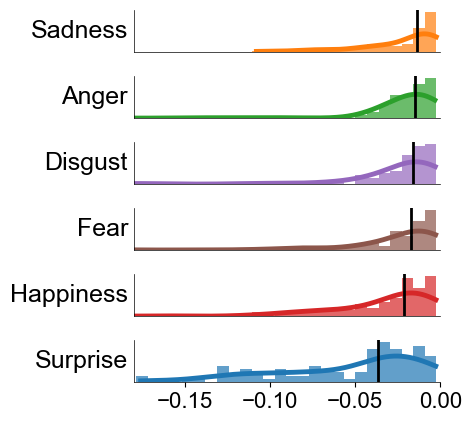

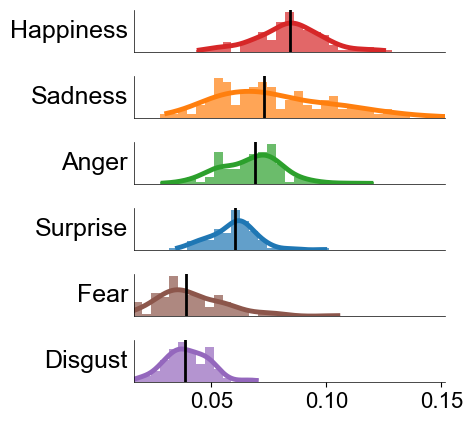

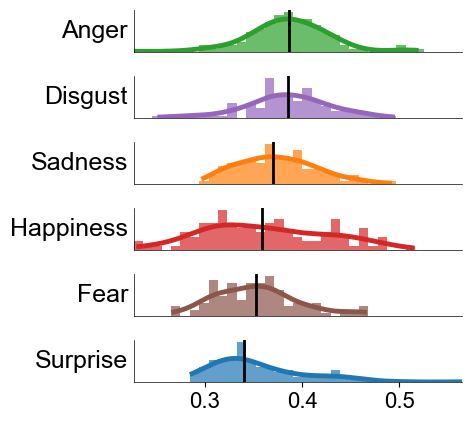

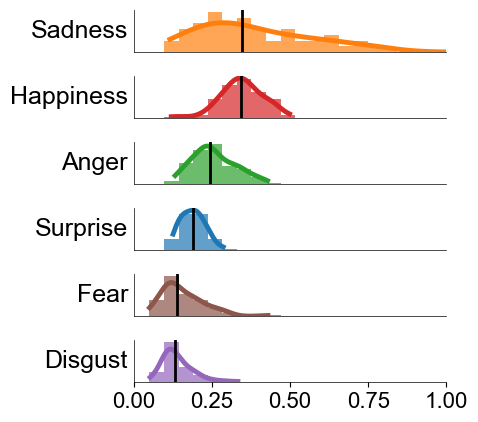

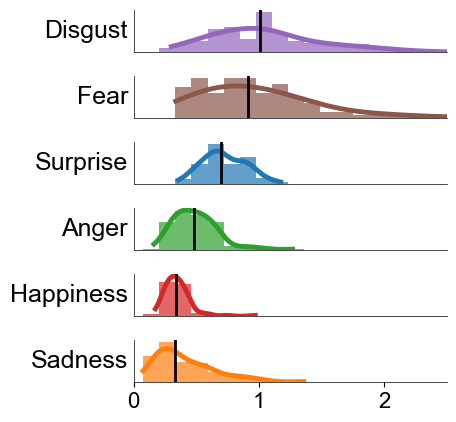

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16

colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
features = [-lambda_movies, instability_all, Hurst_all, AC_all, MC_all]
xlims = [[-0.18, 0], [np.nan, np.nan], [np.nan, np.nan], [0,1.0], [0,2.5]]
print(features[0].shape)
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"] 
# emos = ['Ha', 'Su', 'Sa', 'An', 'Di', 'Fe']
for j in range(5):
    plt.figure(figsize=(5,4.5))

    median = [np.nanmedian(features[j][:, i]) for i in range(6)]
    sorted_indices = np.argsort(median)[::-1]  

    all_data = np.concatenate([features[j][:, i] for i in range(6)], axis=0) 
    bin_edges = np.histogram(all_data[~np.isnan(all_data)], bins=35)[1]  
    
    for i, idx in enumerate(sorted_indices):  
        plt.subplot(6,1,i+1)

        plt.hist(features[j][:, idx], bins=bin_edges, color=colors[idx], alpha=0.7, density=True)

        kde = gaussian_kde(features[j][:, idx][~np.isnan(features[j][:, idx])])
        x = np.linspace(np.nanmin(features[j][:, idx]), np.nanmax(features[j][:, idx]), 1000)
        plt.plot(x, kde(x), color=colors[idx], linestyle='-', linewidth=3.5)

        median_val = np.nanmedian(features[j][:, idx])
        plt.axvline(median_val, color='black', linewidth=2, linestyle='-')

        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['bottom'].set_linewidth(0.5)
        plt.gca().spines['left'].set_linewidth(0.5)
        
        if i < 5: 
            plt.xticks([])
        plt.yticks([])

        if np.isnan(xlims[j][0]):
            plt.xlim([np.nanmin(features[j]), np.nanmax(features[j])])
        else:
            plt.xlim([xlims[j][0], xlims[j][1]])

        plt.ylabel(emos[idx], rotation=0, ha='right', va='center', fontsize=18)

    plt.tight_layout()
    plt.savefig('figures/%s.svg' % indices_name[j])
    plt.show()


In [37]:
features

[array([[-0.0177274 , -0.03666461, -0.00321457, -0.00348268, -0.0086296 ,
         -0.00277556],
        [-0.04112203, -0.03280697, -0.00289284, -0.0051701 , -0.00442322,
         -0.00293785],
        [-0.0441703 , -0.02998848, -0.02814129, -0.00371542, -0.00415725,
         -0.01155979],
        [-0.07668593, -0.11117296, -0.02162014, -0.23415332, -0.20516132,
         -0.1803911 ],
        [-0.04347995, -0.08603818, -0.01579716, -0.00957501, -0.01265361,
         -0.01560021],
        [-0.0136522 , -0.07192602, -0.01550694, -0.01470566, -0.0138822 ,
         -0.00485793],
        [-0.00339559, -0.00762575, -0.0032865 , -0.00774543, -0.00929657,
         -0.00726549],
        [-0.02119311, -0.08971108, -0.0306195 , -0.02049347, -0.01626817,
         -0.02319789],
        [-0.03154094, -0.02289016, -0.03175952, -0.02672467, -0.0377478 ,
         -0.04837924],
        [-0.03383317, -0.04047268, -0.01049894, -0.01466419, -0.01899398,
         -0.01408792],
        [-0.00809033, -0.02720

In [39]:
features_load = [-lambda_movies_load, instability_all_load, Hurst_all_load, AC_all_load, MC_all_load]
print(features_load)

[array([[-0.0177274 , -0.03666461, -0.00321457, -0.00348268, -0.0086296 ,
        -0.00277556],
       [-0.04112203, -0.03280697, -0.00289284, -0.0051701 , -0.00442322,
        -0.00293785],
       [-0.0441703 , -0.02998848, -0.02814129, -0.00371542, -0.00415725,
        -0.01155979],
       [-0.07668593, -0.11117296, -0.02162014, -0.23415332, -0.20516132,
        -0.1803911 ],
       [-0.04347995, -0.08603818, -0.01579716, -0.00957501, -0.01265361,
        -0.01560021],
       [-0.0136522 , -0.07192602, -0.01550694, -0.01470566, -0.0138822 ,
        -0.00485793],
       [-0.00339559, -0.00762575, -0.0032865 , -0.00774543, -0.00929657,
        -0.00726549],
       [-0.02119311, -0.08971108, -0.0306195 , -0.02049347, -0.01626817,
        -0.02319789],
       [-0.03154094, -0.02289016, -0.03175952, -0.02672467, -0.0377478 ,
        -0.04837924],
       [-0.03383317, -0.04047268, -0.01049894, -0.01466419, -0.01899398,
        -0.01408792],
       [-0.00809033, -0.02720413, -0.00418794, -0

In [44]:
np.nansum(np.abs(np.array(features_load) - np.array(features)))

np.float64(2.816332304216365e-08)

In [11]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

for kk in range(5):
    print(indices_name[kk])
    p_values = []
    pairs = []
    for i in range(6):
        for j in range(i + 1, 6):
            t, p = stats.ttest_rel(features[kk][:, i][~np.isnan(features[kk][:, i])], features[kk][:, j][~np.isnan(features[kk][:, i])])
            # print(emos_sorted[i], emos_sorted[j],t,p)
            p_values.append(p)
            pairs.append((emos[i], emos[j]))

    # 对 p 值进行多重检验校正（使用 Bonferroni 校正）
    rejected, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

    # 打印校正后的 p 值
    for i, (pair, p_corr) in enumerate(zip(pairs, corrected_p_values)):
        print(f"Comparison between {pair[0]} and {pair[1]}: p = {p_corr:.4f}")

inertia
Comparison between Happiness and Surprise: p = 0.0000
Comparison between Happiness and Sadness: p = 0.0014
Comparison between Happiness and Anger: p = 0.0004
Comparison between Happiness and Disgust: p = 0.0248
Comparison between Happiness and Fear: p = 0.0570
Comparison between Surprise and Sadness: p = 0.0000
Comparison between Surprise and Anger: p = 0.0000
Comparison between Surprise and Disgust: p = 0.0000
Comparison between Surprise and Fear: p = 0.0000
Comparison between Sadness and Anger: p = 0.6177
Comparison between Sadness and Disgust: p = 0.3525
Comparison between Sadness and Fear: p = 0.2856
Comparison between Anger and Disgust: p = 0.0034
Comparison between Anger and Fear: p = 0.0248
Comparison between Disgust and Fear: p = 0.8873
instability
Comparison between Happiness and Surprise: p = 0.0000
Comparison between Happiness and Sadness: p = 0.0519
Comparison between Happiness and Anger: p = 0.0000
Comparison between Happiness and Disgust: p = 0.0000
Comparison bet

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy import stats
from statsmodels.stats.multitest import multipletests

def _stars_from_p(p):
    if not np.isfinite(p): return ""
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return ""

def pairwise_t_mats(feature_matrix_2d, emo_names, alpha=0.05, fdr_method='fdr_bh'):
    E = len(emo_names)
    t_mat = np.full((E, E), np.nan)
    q_mat = np.full((E, E), np.nan)

    p_list, ij_list, t_cache = [], [], {}
    for i in range(E):
        for j in range(i+1, E):
            a, b = feature_matrix_2d[:, i], feature_matrix_2d[:, j]
            mask = np.isfinite(a) & np.isfinite(b)
            if mask.sum() >= 2:
                tval, pval = stats.ttest_rel(a[mask], b[mask])
            else:
                tval, pval = np.nan, np.nan
            t_cache[(i, j)] = tval
            p_list.append(pval)
            ij_list.append((i, j))

    p_arr = np.asarray(p_list)
    finite = np.isfinite(p_arr)
    q_arr = np.full_like(p_arr, np.nan)
    if finite.any():
        _, q_f, _, _ = multipletests(p_arr[finite], alpha=alpha, method=fdr_method)
        q_arr[finite] = q_f

    for k, (i, j) in enumerate(ij_list):
        tval, qval = t_cache[(i, j)], q_arr[k]
        t_mat[i, j] = tval
        t_mat[j, i] = -tval if np.isfinite(tval) else np.nan
        q_mat[i, j] = qval
        q_mat[j, i] = qval

    np.fill_diagonal(t_mat, np.nan)
    np.fill_diagonal(q_mat, np.nan)
    sig_mat = q_mat < alpha
    return t_mat, q_mat, sig_mat

def plot_lower_triangle_heatmap_clean(
    t_mat, q_mat, sig_mat, emo_names, index_name,
    annotate_stars=True,
    cmap='coolwarm',
    grid_lw=0.6,                 # 统一格线粗细（同时用于左/下边框）
    label_fontsize=10,           # 坐标与colorbar字体
    cbar_fraction=0.02, cbar_pad=0.02
):
    E = len(emo_names)
    lower_mask = np.tril(np.ones((E, E), bool), k=-1)

    t_show = np.where(sig_mat & lower_mask, t_mat, np.nan)

    finite_abs = np.abs(t_show[np.isfinite(t_show)])
    vmax = np.percentile(finite_abs, 95) if finite_abs.size else 1.0
    vmax = max(vmax, 1.0)

    fig, ax = plt.subplots(figsize=(6.3, 4.6), dpi=150)

    hm = sns.heatmap(
        t_show, cmap=cmap, center=0, vmin=-vmax, vmax=vmax,
        xticklabels=emo_names, yticklabels=emo_names, square=True,
        linewidths=0, linecolor=None, cbar=False
        # cbar_kws={'label': 't (significant)', 'fraction': cbar_fraction, 'pad': cbar_pad}
    )
    ax.set_xticks([])
    ax.set_yticks([])

    bbox = ax.get_position()
    cax = fig.add_axes([
        bbox.x0 + bbox.width*0.52,     # x 起点（靠右上）
        bbox.y0 + bbox.height*0.88,    # y 起点（靠上）
        bbox.width*0.46,               # 宽度（占右上角）
        0.03                           # 高度（细条）
    ])
    cb = plt.colorbar(hm.collections[0], cax=cax, orientation='horizontal')
    cb.ax.tick_params(axis='x', which='both', labelbottom=False)  # 水平 colorbar
    # cb.ax.tick_params(labelsize=label_fontsize)
    # cb.set_label('t-score', fontsize=label_fontsize)

    for i in range(E):
        for j in range(E):
            if i > j:  # 严格下三角
                ax.add_patch(Rectangle(
                    (j, i), 1, 1, fill=False,
                    edgecolor='black', linewidth=grid_lw, zorder=5
                ))
    for side in ('top', 'right'):
        ax.spines[side].set_visible(False)
    for side in ('left', 'bottom'):
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(grid_lw)
        ax.spines[side].set_color('black')

    if annotate_stars:
        for i in range(E):
            for j in range(E):
                if i > j and sig_mat[i, j] and np.isfinite(q_mat[i, j]):
                    p = q_mat[i, j]
                    star = "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 5e-2 else ""
                    if star:
                        ax.text(j + 0.5, i + 0.6, star,
                                ha='center', va='center',
                                fontsize=label_fontsize-1, color='black', zorder=6)

    plt.tight_layout()
    plt.savefig('figures/%s_ttest.svg' % index_name, bbox_inches='tight')
    plt.show()


inertia


C:\Users\Windows\AppData\Local\Temp\ipykernel_22716\2130021843.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


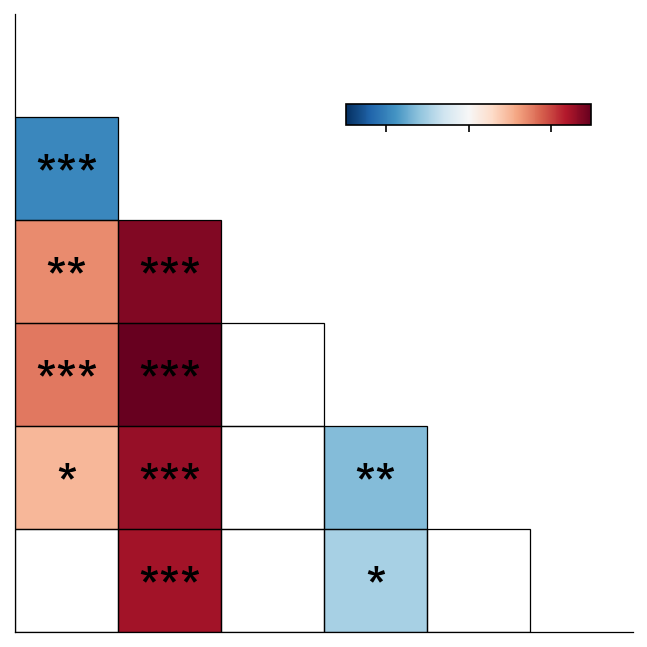

instability


C:\Users\Windows\AppData\Local\Temp\ipykernel_22716\2130021843.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


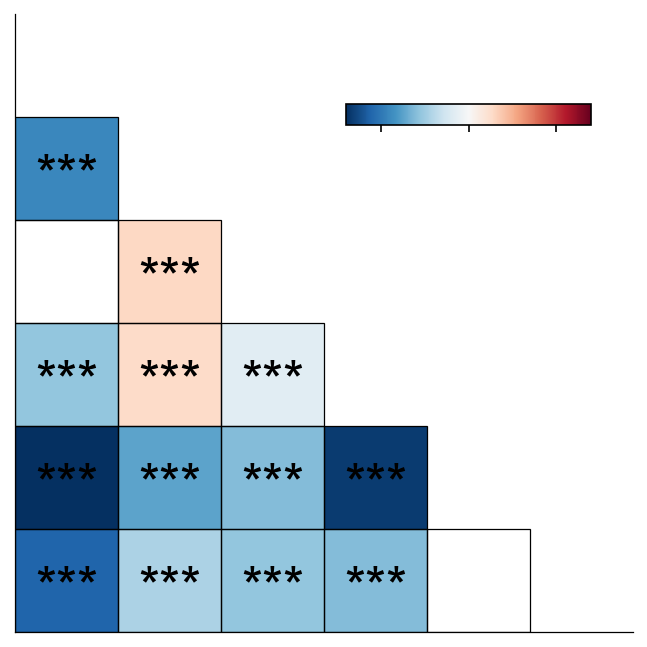

self_similarity


C:\Users\Windows\AppData\Local\Temp\ipykernel_22716\2130021843.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


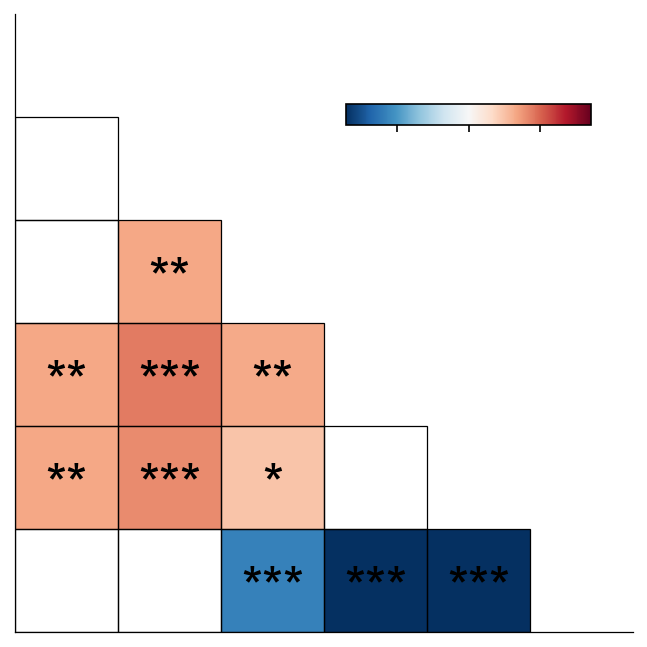

AC


C:\Users\Windows\AppData\Local\Temp\ipykernel_22716\2130021843.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


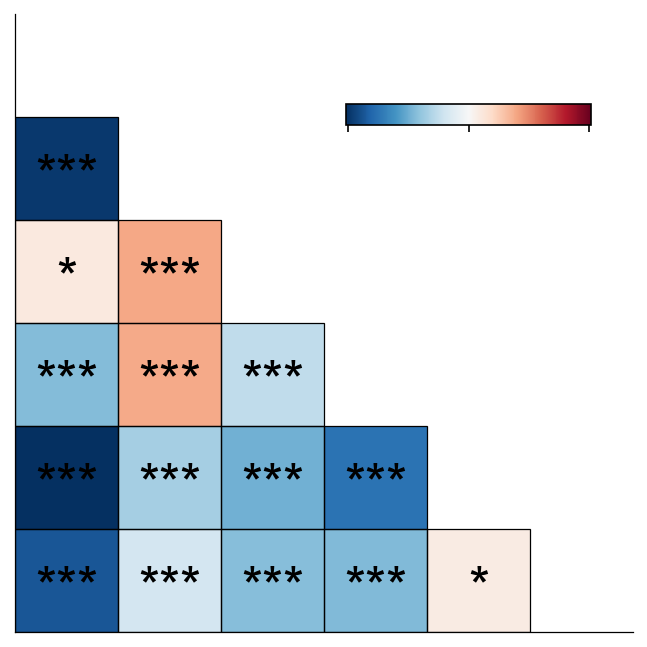

MC


C:\Users\Windows\AppData\Local\Temp\ipykernel_22716\2130021843.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


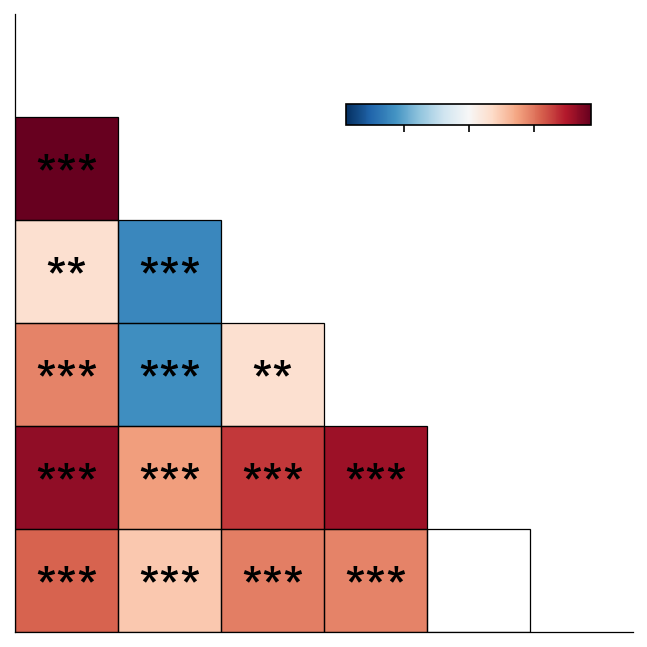

In [13]:
emos = ['Happiness', 'Surprise', 'Sadness', 'Anger', 'Disgust', 'Fear']
for kk in range(5):
    print(indices_name[kk])
    t_mat, q_mat, sig_mat = pairwise_t_mats(features[kk], emos, alpha=0.05, fdr_method='fdr_bh')
    plot_lower_triangle_heatmap_clean(t_mat, q_mat, sig_mat, emos, indices_name[kk], cmap='RdBu_r',
                                    grid_lw=0.6, label_fontsize=27,
                                    cbar_fraction=0.02, cbar_pad=0.02)